In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import seaborn as sns

In [3]:
access_token = ''

In [5]:
client = oandapyV20.API(access_token=access_token)

In [167]:
params = {"count": 5000, "granularity": "D"}

In [168]:
r = instruments.InstrumentsCandles(instrument="USD_CNH", params=params)

In [169]:
client.request(r)

{'candles': [{'complete': True,
   'mid': {'c': '6.55550', 'h': '6.56300', 'l': '6.55452', 'o': '6.55950'},
   'time': '2011-02-06T22:00:00.000000000Z',
   'volume': 42},
  {'complete': True,
   'mid': {'c': '6.55750', 'h': '6.56552', 'l': '6.55050', 'o': '6.55500'},
   'time': '2011-02-07T22:00:00.000000000Z',
   'volume': 75},
  {'complete': True,
   'mid': {'c': '6.56500', 'h': '6.66500', 'l': '6.55650', 'o': '6.55900'},
   'time': '2011-02-08T22:00:00.000000000Z',
   'volume': 39},
  {'complete': True,
   'mid': {'c': '6.57950', 'h': '6.58202', 'l': '6.57550', 'o': '6.57550'},
   'time': '2011-02-12T22:00:00.000000000Z',
   'volume': 28},
  {'complete': True,
   'mid': {'c': '6.57250', 'h': '6.62950', 'l': '6.57250', 'o': '6.57850'},
   'time': '2011-02-13T22:00:00.000000000Z',
   'volume': 62},
  {'complete': True,
   'mid': {'c': '6.56500', 'h': '6.57752', 'l': '6.56350', 'o': '6.57402'},
   'time': '2011-02-14T22:00:00.000000000Z',
   'volume': 72},
  {'complete': True,
   'mid'

In [170]:
r.response['candles'][0]

{'complete': True,
 'mid': {'c': '6.55550', 'h': '6.56300', 'l': '6.55452', 'o': '6.55950'},
 'time': '2011-02-06T22:00:00.000000000Z',
 'volume': 42}

In [171]:
df = []

for i in r.response['candles']:
    df.append([i['time'], 
               pd.to_numeric(i['volume']), 
               pd.to_numeric(i['mid']['o']), 
               pd.to_numeric(i['mid']['h']), 
               pd.to_numeric(i['mid']['l']), 
               pd.to_numeric(i['mid']['c'])]
               )

In [172]:
df = pd.DataFrame(df)
df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
df = df.set_index('Time')
df.index = df.index.astype('datetime64[ns]')

In [173]:
df.head()

,Volume,Open,High,Low,Close
Time,,,,,
2011-02-06 22:00:00,42,6.5595,6.56300,6.55452,6.5555
2011-02-07 22:00:00,75,6.5550,6.56552,6.55050,6.5575
2011-02-08 22:00:00,39,6.5590,6.66500,6.55650,6.5650
2011-02-12 22:00:00,28,6.5755,6.58202,6.57550,6.5795
2011-02-13 22:00:00,62,6.5785,6.62950,6.57250,6.5725


In [177]:
df.tail()

,Volume,Open,High,Low,Close
Time,,,,,
2018-01-18 22:00:00,197208,6.42183,6.42183,6.38817,6.40025
2018-01-21 22:00:00,128172,6.39698,6.41394,6.39361,6.40298
2018-01-22 22:00:00,148321,6.40282,6.41377,6.39077,6.39859
2018-01-23 22:00:00,178650,6.39856,6.40014,6.34613,6.34923
2018-01-24 22:00:00,254497,6.34880,6.35952,6.29847,6.30479


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1949 entries, 2011-02-06 22:00:00 to 2018-01-24 22:00:00
Data columns (total 5 columns):
Volume    1949 non-null int64
Open      1949 non-null float64
High      1949 non-null float64
Low       1949 non-null float64
Close     1949 non-null float64
dtypes: float64(4), int64(1)
memory usage: 91.4 KB


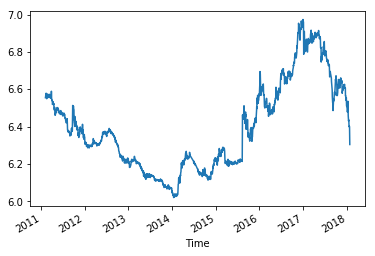

In [175]:
df['Close'].plot()

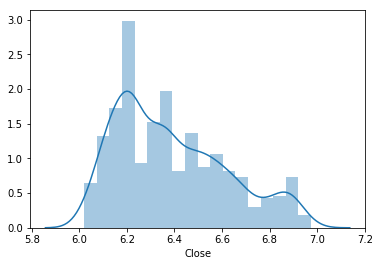

In [176]:
sns.distplot(df['Close'])

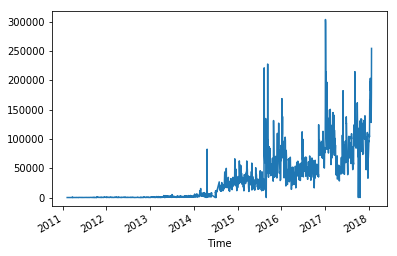

In [178]:
df['Volume'].plot()

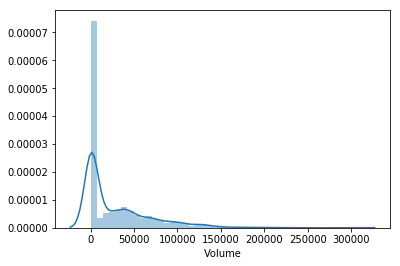

In [179]:
sns.distplot(df['Volume'])

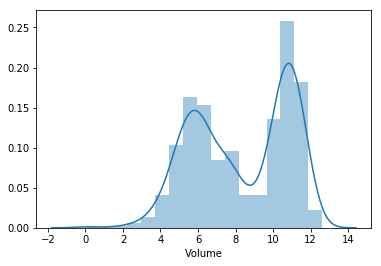

In [180]:
sns.distplot(np.log(df['Volume']))

In [309]:
# XGBoost Approach
import xgboost as xgb
#from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'binary:logistic', # classification task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [293]:
df_test = df.copy()

In [294]:
df_test.shape

(1949, 5)

In [295]:
df_test['Return'] = df_test['Close'].pct_change(1)

In [296]:
df_test['Log Return'] = np.log(df_test['Return'] + 1)

In [297]:
def create_lag(df, lag_input, lag_output):
    for i in range(1,6):
        df[lag_output + str(i)] = df[lag_input].shift(i)
    return df

In [298]:
dt_test = create_lag(df_test, 'Volume', 'Volume_lag_')
dt_test = create_lag(df_test, 'Open', 'Open_lag_')
dt_test = create_lag(df_test, 'High', 'High_lag_')
dt_test = create_lag(df_test, 'Low', 'Low_lag_')
dt_test = create_lag(df_test, 'Close', 'Close_lag_')

In [299]:
df_test.head()

,Volume,Open,High,Low,Close,Return,Log Return,Volume_lag_1,Volume_lag_2,Volume_lag_3,...,Low_lag_1,Low_lag_2,Low_lag_3,Low_lag_4,Low_lag_5,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
Time,,,,,,,,,,,,,,,,,,,,,
2011-02-06 22:00:00,42,6.5595,6.56300,6.55452,6.5555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-07 22:00:00,75,6.5550,6.56552,6.55050,6.5575,0.000305,0.000305,42.0,NaN,NaN,...,6.55452,NaN,NaN,NaN,NaN,6.5555,NaN,NaN,NaN,NaN
2011-02-08 22:00:00,39,6.5590,6.66500,6.55650,6.5650,0.001144,0.001143,75.0,42.0,NaN,...,6.55050,6.55452,NaN,NaN,NaN,6.5575,6.5555,NaN,NaN,NaN
2011-02-12 22:00:00,28,6.5755,6.58202,6.57550,6.5795,0.002209,0.002206,39.0,75.0,42.0,...,6.55650,6.55050,6.55452,NaN,NaN,6.5650,6.5575,6.5555,NaN,NaN
2011-02-13 22:00:00,62,6.5785,6.62950,6.57250,6.5725,-0.001064,-0.001064,28.0,39.0,75.0,...,6.57550,6.55650,6.55050,6.55452,NaN,6.5795,6.5650,6.5575,6.5555,NaN


In [300]:
df_test.dropna(inplace = True)

In [301]:
df_test.head()

,Volume,Open,High,Low,Close,Return,Log Return,Volume_lag_1,Volume_lag_2,Volume_lag_3,...,Low_lag_1,Low_lag_2,Low_lag_3,Low_lag_4,Low_lag_5,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
Time,,,,,,,,,,,,,,,,,,,,,
2011-02-14 22:00:00,72,6.57402,6.57752,6.5635,6.5650,-0.001141,-0.001142,62.0,28.0,39.0,...,6.5725,6.5755,6.5565,6.5505,6.55452,6.5725,6.5795,6.5650,6.5575,6.5555
2011-02-15 22:00:00,105,6.56352,6.57550,6.5545,6.5645,-0.000076,-0.000076,72.0,62.0,28.0,...,6.5635,6.5725,6.5755,6.5565,6.55050,6.5650,6.5725,6.5795,6.5650,6.5575
2011-02-16 22:00:00,76,6.56550,6.56652,6.5605,6.5635,-0.000152,-0.000152,105.0,72.0,62.0,...,6.5545,6.5635,6.5725,6.5755,6.55650,6.5645,6.5650,6.5725,6.5795,6.5650
2011-02-17 22:00:00,32,6.56400,6.57050,6.5500,6.5500,-0.002057,-0.002059,76.0,105.0,72.0,...,6.5605,6.5545,6.5635,6.5725,6.57550,6.5635,6.5645,6.5650,6.5725,6.5795
2011-02-19 22:00:00,54,6.55878,6.56250,6.5505,6.5570,0.001069,0.001068,32.0,76.0,105.0,...,6.5500,6.5605,6.5545,6.5635,6.57250,6.5500,6.5635,6.5645,6.5650,6.5725


In [302]:
df_test['Target'] = np.where(df_test['Return'] > 0, 1, 0)

In [303]:
df_test.head()

,Volume,Open,High,Low,Close,Return,Log Return,Volume_lag_1,Volume_lag_2,Volume_lag_3,...,Low_lag_2,Low_lag_3,Low_lag_4,Low_lag_5,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Target
Time,,,,,,,,,,,,,,,,,,,,,
2011-02-14 22:00:00,72,6.57402,6.57752,6.5635,6.5650,-0.001141,-0.001142,62.0,28.0,39.0,...,6.5755,6.5565,6.5505,6.55452,6.5725,6.5795,6.5650,6.5575,6.5555,0
2011-02-15 22:00:00,105,6.56352,6.57550,6.5545,6.5645,-0.000076,-0.000076,72.0,62.0,28.0,...,6.5725,6.5755,6.5565,6.55050,6.5650,6.5725,6.5795,6.5650,6.5575,0
2011-02-16 22:00:00,76,6.56550,6.56652,6.5605,6.5635,-0.000152,-0.000152,105.0,72.0,62.0,...,6.5635,6.5725,6.5755,6.55650,6.5645,6.5650,6.5725,6.5795,6.5650,0
2011-02-17 22:00:00,32,6.56400,6.57050,6.5500,6.5500,-0.002057,-0.002059,76.0,105.0,72.0,...,6.5545,6.5635,6.5725,6.57550,6.5635,6.5645,6.5650,6.5725,6.5795,0
2011-02-19 22:00:00,54,6.55878,6.56250,6.5505,6.5570,0.001069,0.001068,32.0,76.0,105.0,...,6.5605,6.5545,6.5635,6.57250,6.5500,6.5635,6.5645,6.5650,6.5725,1


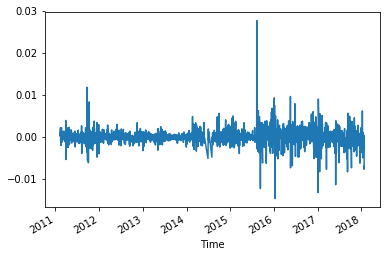

In [186]:
df_test['Return'].plot()

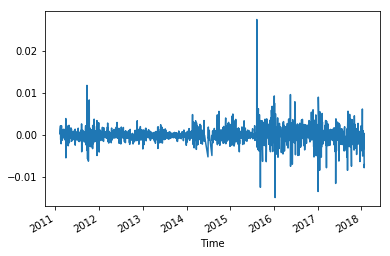

In [187]:
df_test['Log Return'].plot()

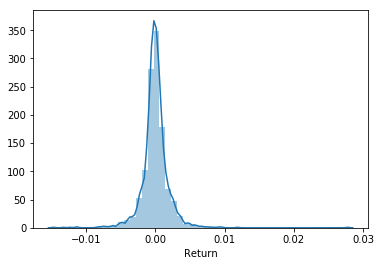

In [188]:
sns.distplot(df_test['Return'][1:])

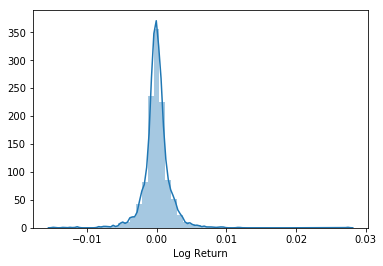

In [189]:
sns.distplot(df_test['Log Return'][1:])

In [133]:
df.head()

,Volume,Open,High,Low,Close
Time,,,,,
2017-04-05 05:00:00,930,6.87813,6.87894,6.87774,6.87880
2017-04-05 06:00:00,3001,6.87882,6.88044,6.87863,6.87863
2017-04-05 07:00:00,4005,6.87862,6.88148,6.87802,6.88139
2017-04-05 08:00:00,2879,6.88138,6.88459,6.88122,6.88434
2017-04-05 09:00:00,2529,6.88434,6.88664,6.88355,6.88398


In [304]:
#X_cols = ['Volume', 'Open', 'High', 'Low']
y_cols = ['Target']

In [305]:
train = df_test.iloc[:-(100),:].copy()
test = df_test.iloc[-(100):,:].copy()

In [306]:
X_train = train[train.columns.difference(['Volume', 'Open', 'Close', 'High', 'Low', 'Return', 'Log Return', 'Target'])].values.copy()
y_train = train[y_cols].values.copy()
X_test = test[test.columns.difference(['Volume', 'Open', 'Close', 'High', 'Low', 'Return', 'Log Return', 'Target'])].values.copy()
y_test = test[y_cols].values.copy()

In [308]:
X_train.shape

(1844, 25)

In [310]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

#xgb_model = xgb.train(params, dtrain, 300, evals = watchlist, early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)
xgb_model = xgb.train(params, dtrain, 500, evals = watchlist, verbose_eval = True)

[0]	train-error:0.300976	test-error:0.53
[1]	train-error:0.242408	test-error:0.58
[2]	train-error:0.191974	test-error:0.59
[3]	train-error:0.173536	test-error:0.59
[4]	train-error:0.164317	test-error:0.59
[5]	train-error:0.153471	test-error:0.57
[6]	train-error:0.150759	test-error:0.57
[7]	train-error:0.140998	test-error:0.55
[8]	train-error:0.120933	test-error:0.56
[9]	train-error:0.111171	test-error:0.56
[10]	train-error:0.110087	test-error:0.58
[11]	train-error:0.095445	test-error:0.56
[12]	train-error:0.096529	test-error:0.56
[13]	train-error:0.080803	test-error:0.56
[14]	train-error:0.075922	test-error:0.55
[15]	train-error:0.071584	test-error:0.58
[16]	train-error:0.07321	test-error:0.53
[17]	train-error:0.070499	test-error:0.54
[18]	train-error:0.067245	test-error:0.54
[19]	train-error:0.060195	test-error:0.53
[20]	train-error:0.061822	test-error:0.52
[21]	train-error:0.058568	test-error:0.54
[22]	train-error:0.053688	test-error:0.54
[23]	train-error:0.051518	test-error:0.51
[24

[206]	train-error:0	test-error:0.51
[207]	train-error:0	test-error:0.51
[208]	train-error:0	test-error:0.52
[209]	train-error:0	test-error:0.52
[210]	train-error:0	test-error:0.52
[211]	train-error:0	test-error:0.52
[212]	train-error:0	test-error:0.53
[213]	train-error:0	test-error:0.52
[214]	train-error:0	test-error:0.52
[215]	train-error:0	test-error:0.53
[216]	train-error:0	test-error:0.53
[217]	train-error:0	test-error:0.53
[218]	train-error:0	test-error:0.51
[219]	train-error:0	test-error:0.51
[220]	train-error:0	test-error:0.51
[221]	train-error:0	test-error:0.51
[222]	train-error:0	test-error:0.51
[223]	train-error:0	test-error:0.52
[224]	train-error:0	test-error:0.53
[225]	train-error:0	test-error:0.51
[226]	train-error:0	test-error:0.51
[227]	train-error:0	test-error:0.5
[228]	train-error:0	test-error:0.49
[229]	train-error:0	test-error:0.49
[230]	train-error:0	test-error:0.51
[231]	train-error:0	test-error:0.52
[232]	train-error:0	test-error:0.52
[233]	train-error:0	test-erro

[435]	train-error:0	test-error:0.45
[436]	train-error:0	test-error:0.45
[437]	train-error:0	test-error:0.45
[438]	train-error:0	test-error:0.44
[439]	train-error:0	test-error:0.44
[440]	train-error:0	test-error:0.44
[441]	train-error:0	test-error:0.44
[442]	train-error:0	test-error:0.44
[443]	train-error:0	test-error:0.44
[444]	train-error:0	test-error:0.44
[445]	train-error:0	test-error:0.44
[446]	train-error:0	test-error:0.44
[447]	train-error:0	test-error:0.44
[448]	train-error:0	test-error:0.44
[449]	train-error:0	test-error:0.44
[450]	train-error:0	test-error:0.45
[451]	train-error:0	test-error:0.45
[452]	train-error:0	test-error:0.45
[453]	train-error:0	test-error:0.45
[454]	train-error:0	test-error:0.45
[455]	train-error:0	test-error:0.45
[456]	train-error:0	test-error:0.45
[457]	train-error:0	test-error:0.45
[458]	train-error:0	test-error:0.45
[459]	train-error:0	test-error:0.45
[460]	train-error:0	test-error:0.45
[461]	train-error:0	test-error:0.45
[462]	train-error:0	test-err

In [311]:
yhat = xgb_model.predict(xgb.DMatrix(X_test))
yhat_train = xgb_model.predict(xgb.DMatrix(X_train))

In [320]:
yhat

array([ 0.77921653,  0.33665866,  0.40459898,  0.08734559,  0.09786645,
        0.26555324,  0.02571929,  0.03241456,  0.22355205,  0.2619375 ,
        0.82586366,  0.4671458 ,  0.71757346,  0.51314324,  0.49614739,
        0.65869826,  0.680632  ,  0.19021787,  0.25394657,  0.23204875,
        0.78821278,  0.9183808 ,  0.09238754,  0.47244868,  0.34234402,
        0.73948729,  0.77916574,  0.58247769,  0.2450566 ,  0.90297198,
        0.71977782,  0.5351519 ,  0.2925308 ,  0.08167017,  0.52014798,
        0.250175  ,  0.86033958,  0.8775202 ,  0.93214494,  0.8035205 ,
        0.14337769,  0.411928  ,  0.48948386,  0.28377777,  0.04619155,
        0.27321249,  0.57572919,  0.91415846,  0.76360452,  0.69583738,
        0.62459463,  0.85880339,  0.58714527,  0.14326328,  0.48531377,
        0.65764242,  0.78004384,  0.65401322,  0.59405822,  0.39713714,
        0.45747632,  0.53633416,  0.76669782,  0.82000554,  0.63216859,
        0.69612086,  0.25119123,  0.67593002,  0.79954499,  0.10

In [328]:
yhat_class = np.where(yhat>0.5, 1, 0)
yhat_train_class = np.where(yhat_train>0.5, 1, 0)

In [334]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [332]:
print(classification_report(y_train, yhat_train_class))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       964
          1       1.00      1.00      1.00       880

avg / total       1.00      1.00      1.00      1844



In [330]:
print(classification_report(y_test, yhat_class))

             precision    recall  f1-score   support

          0       0.57      0.57      0.57        54
          1       0.50      0.50      0.50        46

avg / total       0.54      0.54      0.54       100



In [357]:
y_test.sum()

46

In [348]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black"
                 #color="white" if cm[i, j] > thresh else "black"
                )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[31 23]
 [23 23]]
Normalized confusion matrix
[[ 0.57  0.43]
 [ 0.5   0.5 ]]


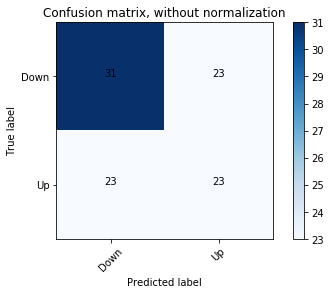

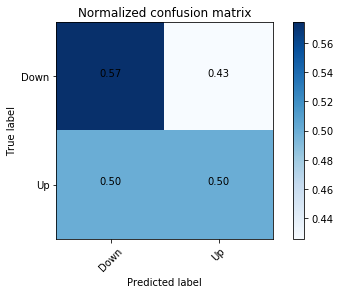

In [349]:
import itertools
class_names = ['Down', 'Up']
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

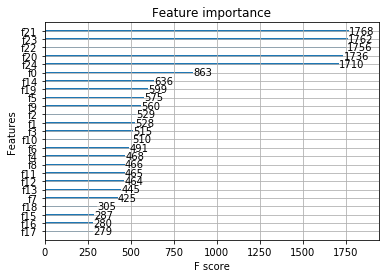

In [359]:
xgb.plot_importance(xgb_model)

In [362]:
for i,j in enumerate(train[train.columns.difference(['Volume', 'Open', 'Close', 'High', 'Low', 'Return', 'Log Return', 'Target'])]):
    print(i,j)

0 Close_lag_1
1 Close_lag_2
2 Close_lag_3
3 Close_lag_4
4 Close_lag_5
5 High_lag_1
6 High_lag_2
7 High_lag_3
8 High_lag_4
9 High_lag_5
10 Low_lag_1
11 Low_lag_2
12 Low_lag_3
13 Low_lag_4
14 Low_lag_5
15 Open_lag_1
16 Open_lag_2
17 Open_lag_3
18 Open_lag_4
19 Open_lag_5
20 Volume_lag_1
21 Volume_lag_2
22 Volume_lag_3
23 Volume_lag_4
24 Volume_lag_5


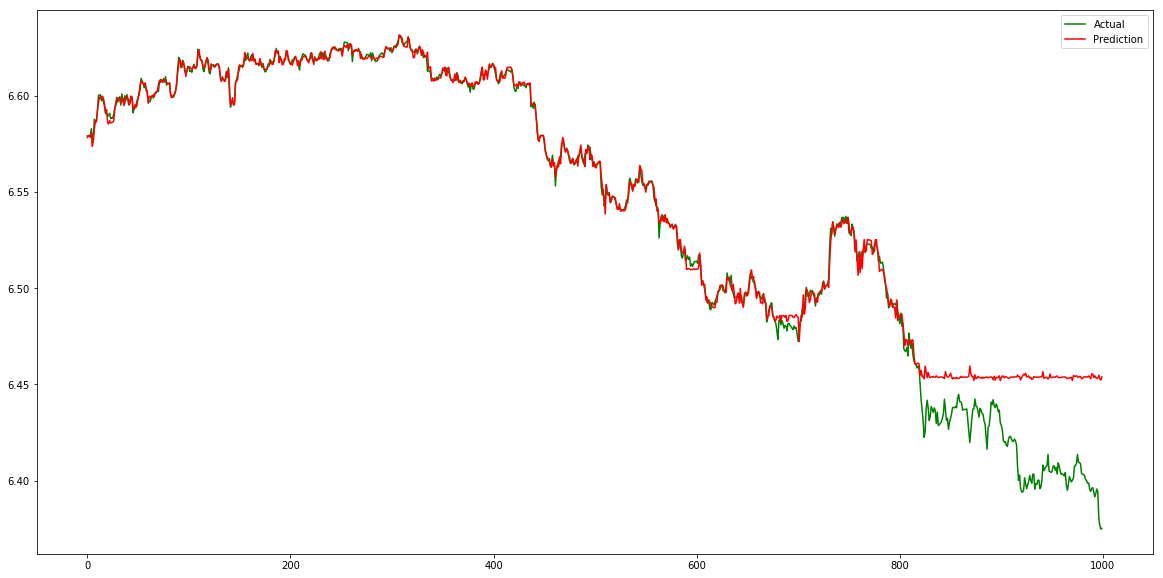

In [125]:
plt.figure(figsize = (20, 10))
plt.plot(y_test, color ='g', label = 'Actual')
plt.plot(yhat, color = 'r', label = 'Prediction')
plt.legend()

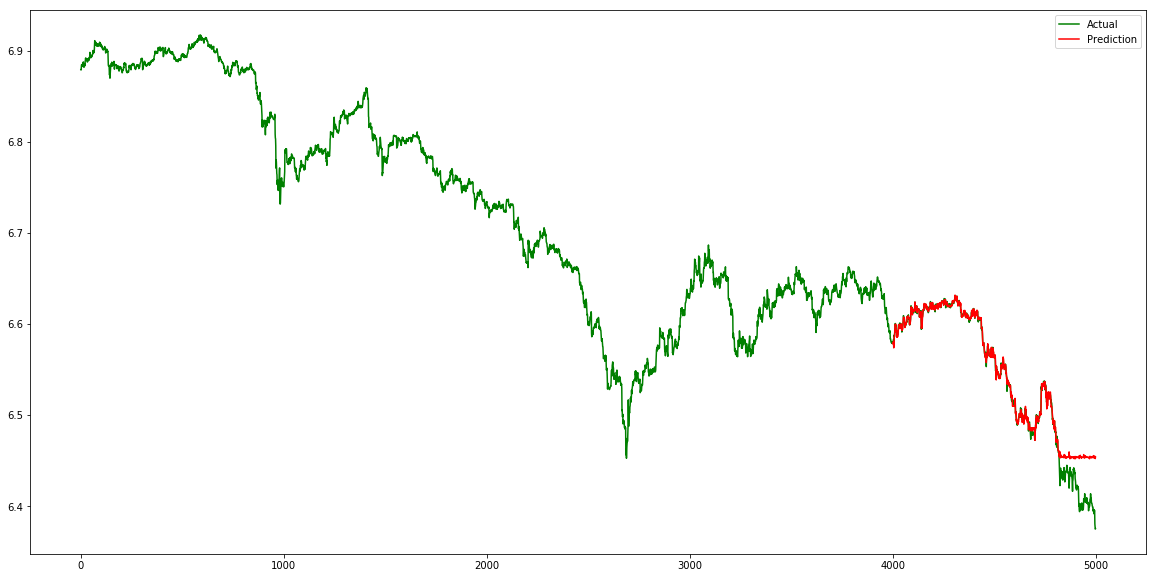

In [127]:
plt.figure(figsize = (20, 10))
plt.plot([y for y in y_train] + [y for y in y_test], color ='g', label = 'Actual')
plt.plot([None for y in yhat_train] + [y for y in yhat], color = 'r', label = 'Prediction')
plt.legend()

In [130]:
yhat_all = xgb_model.predict(xgb.DMatrix(all))

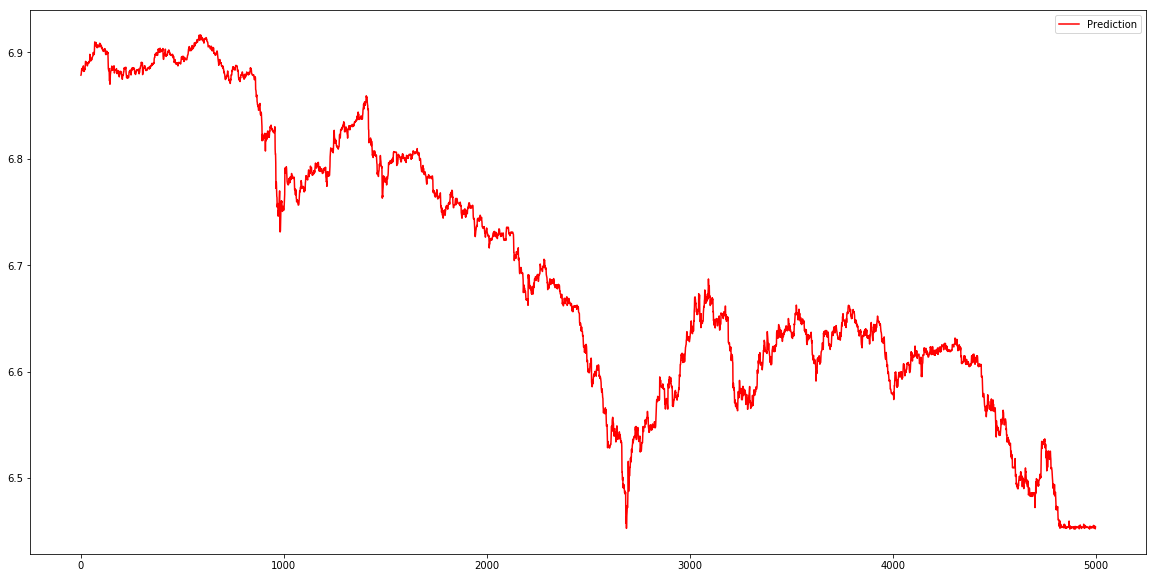

In [132]:
plt.figure(figsize = (20, 10))
plt.plot([y for y in yhat_all], color = 'r', label = 'Prediction')
plt.legend()